In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.api import OLS, add_constant
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef



Postures = pd.read_csv("Postures.csv")

def printClassResults(truth, preds):
    print("The Accuracy is: %7.4f" % accuracy_score(truth, preds))
    print("The Precision is: %7.4f" % precision_score(y_test, preds,average='micro'))
    print("The Recall is: %7.4f"    % recall_score(y_test, preds,average='micro'))
    print("The F1 score is: %7.4f"  % f1_score(y_test, preds,average='micro'))
    print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, preds))
    print()
    print("This is the Confusion Matrix")
    display(pd.DataFrame(confusion_matrix(truth, preds)))

# 1) Processing the Data Set

In [2]:
# Eliminate first instance of Postures (all 0's) 
df = Postures.iloc[1:]

for col in df.columns:
    proportion = (df[col] == '?').mean()*100
    if proportion > 0:
        print(f'Proportion of missing values in column {col}: {round(proportion,2)}%')

Proportion of missing values in column X3: 0.88%
Proportion of missing values in column Y3: 0.88%
Proportion of missing values in column Z3: 0.88%
Proportion of missing values in column X4: 4.0%
Proportion of missing values in column Y4: 4.0%
Proportion of missing values in column Z4: 4.0%
Proportion of missing values in column X5: 16.68%
Proportion of missing values in column Y5: 16.68%
Proportion of missing values in column Z5: 16.68%
Proportion of missing values in column X6: 33.1%
Proportion of missing values in column Y6: 33.1%
Proportion of missing values in column Z6: 33.1%
Proportion of missing values in column X7: 50.13%
Proportion of missing values in column Y7: 50.13%
Proportion of missing values in column Z7: 50.13%
Proportion of missing values in column X8: 60.86%
Proportion of missing values in column Y8: 60.86%
Proportion of missing values in column Z8: 60.86%
Proportion of missing values in column X9: 69.31%
Proportion of missing values in column Y9: 69.31%
Proportion o

In [3]:
#removing the variables with a proportion of missing values more than 80% 
for col in df.columns:
    proportion = (df[col] == '?').mean()*100
    if proportion > 80:
        df=df.drop(col, axis=1)

In [4]:
# Replace all '?' to NaN, so that the values are valid for Imputation
for col in df.columns:
    df.loc[df[col] == '?', col] = np.nan
        
X= df.drop(columns =[ 'Class' ]) 
y=df['Class']  

In [5]:
# Consider the User variable as categorical (even though it is numeric)
Postures['User'] = Postures['User'].astype('category')

In [6]:
# Divide the whole Set into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25)

In [7]:
# Instatiate a Simple Imputater
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    
# Acquire a new DataFrame with Imputated Values
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test  = imputer.transform(X_test)

In [8]:
# Scaling the data
scaler   = PowerTransformer()
scaler.fit(X_train)
Xt_train = scaler.transform(X_train)
Xt_test  = scaler.transform(X_test)

# 2) Tree Based Models

In [9]:
import time

# Record the start time
start_time = time.time()

# Create a Decision Tree Model with the data
tree_mdl = DecisionTreeClassifier()

# Hyperparameter tuning using GridSearchCV (taking ~53 seconds)
parameters = {
    'criterion': ['entropy'],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1]
}

grid_search = GridSearchCV(tree_mdl, parameters, scoring='accuracy', cv=5)
grid_search.fit(Xt_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best hyperparameters to create the final model
final_tree_mdl = DecisionTreeClassifier(**best_params)
final_tree_mdl.fit(Xt_train, y_train)
preds = final_tree_mdl.predict(Xt_test)

# Evaluate the results
printClassResults(y_test, preds)

# Cross-validated accuracy
cv_accuracy = cross_val_score(final_tree_mdl, Xt_train, y_train, cv=5, scoring='accuracy')
print("Cross-validated Accuracy:", np.mean(cv_accuracy))


# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3}
The Accuracy is:  0.8847
The Precision is:  0.8847
The Recall is:  0.8847
The F1 score is:  0.8847
The Matthews correlation coefficient is:  0.8567

This is the Confusion Matrix


,0,1,2,3,4
0,4039,7,9,16,1
1,6,3392,26,40,248
2,207,7,3327,529,45
3,34,33,265,3297,75
4,116,334,53,200,3218


Cross-validated Accuracy: 0.8806746697557981
Execution time: 70.2428970336914 seconds


# 3) Linear Models

In [10]:
# Create a Logistic Regression Model with the data
LR = LogisticRegression(random_state=0).fit(Xt_train, y_train)

# Present the Bias and the Betas
print("The bias is: ",  LR.intercept_[0])
print("The other parameters are: ")
for i, beta in enumerate(LR.coef_[0]):
    print("\t B%02d -> %9.3f"% (i+1, beta))

The bias is:  -0.532558260404442
The other parameters are: 
	 B01 ->    -0.050
	 B02 ->    -1.020
	 B03 ->    -1.125
	 B04 ->    -0.578
	 B05 ->    -0.857
	 B06 ->    -1.211
	 B07 ->    -0.480
	 B08 ->    -0.774
	 B09 ->    -1.299
	 B10 ->    -0.224
	 B11 ->    -0.753
	 B12 ->    -1.461
	 B13 ->     0.068
	 B14 ->    -0.717
	 B15 ->    -1.446
	 B16 ->     0.109
	 B17 ->    -0.637
	 B18 ->    -1.536
	 B19 ->     0.392
	 B20 ->    -0.388
	 B21 ->    -1.349
	 B22 ->     0.690
	 B23 ->    -0.170
	 B24 ->    -0.522
	 B25 ->     0.294
	 B26 ->     0.179
	 B27 ->    -0.551
	 B28 ->     0.141
	 B29 ->     0.271
	 B30 ->    -0.395
	 B31 ->     0.125


In [11]:
X_tr = add_constant(Xt_train)
mdl=OLS(y_train,X_tr, hasconst=12).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Class   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     704.6
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:45:01   Log-Likelihood:                -94420.
No. Observations:               58571   AIC:                         1.889e+05
Df Residuals:                   58539   BIC:                         1.892e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9837      0.005    595.114      0.000       2.974       2.993
x1             0.0192      0.005      3.595      0.000       0.009       0.030
x2             0.1791      0.006     32.186      0.000       0.168       0.190
x3             0.1491      0.006     24.069      0.000       0.137       0.161
x4             0.0756      0.007     10.195      0.000       0.061       0.090
x5             0.0964      0.006     17.130      0.000       0.085       0.107
x6             0.1863      0.006     29.529      0.000       0.174       0.199
x7             0.0551      0.008      7.020      0.000       0.040       0.070
x8             0.0528      0.006      9.275      0.000       0.042       0.064
x9             0.2046      0.006     31.675      0.000       0.192       0.217
x10            0.0198      0.008      2.455      0.014       0.004       0.036
x11            0.0521      0.006      9.042      0.000       0.041       0.063
x12            0.2208      0.007     33.180      0.000       0.208       0.234
x13           -0.0309      0.008     -3.759      0.000      -0.047      -0.015
x14            0.0518      0.006      9.021      0.000       0.041       0.063
x15            0.2336      0.007     34.640      0.000       0.220       0.247
x16           -0.0826      0.008    -10.284      0.000      -0.098      -0.067
x17            0.0032      0.006      0.567      0.571      -0.008       0.014
x18            0.2296      0.007     33.537      0.000       0.216       0.243
x19           -0.1758      0.008    -23.129      0.000      -0.191      -0.161
x20           -0.0481      0.006     -8.620      0.000      -0.059      -0.037
x21            0.2365      0.007     34.988      0.000       0.223       0.250
x22           -0.2995      0.007    -41.807      0.000      -0.314      -0.285
x23           -0.1055      0.006    -18.720      0.000      -0.117      -0.094
x24            0.1825      0.006     29.593      0.000       0.170       0.195
x25           -0.2728      0.006    -42.712      0.000      -0.285      -0.260
x26           -0.0588      0.006    -10.108      0.000      -0.070      -0.047
x27            0.2347      0.007     36.059      0.000       0.222       0.248
x28           -0.1805      0.007    -27.321      0.000      -0.193      -0.168
x29           -0.0078      0.006     -1.310      0.190      -0.020       0.004
x30            0.2556      0.007     38.586      0.000       0.243       0.269
x31           -0.1249      0.006    -19.875      0.000      -0.137      -0.113
==============================================================================
Omnibus:                     1492.045   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              779.935
Skew:                           0.072   Prob(JB):                    4.36e-170
Ku

In [12]:
coefs=[(abs(beta),i) for i, beta in enumerate(LR.coef_[0])]
coefs.sort()
coefs.reverse()
for beta, i in coefs[:5]:
    print("\t B%02d -> %9.3f"% (i+1, beta))

	 B18 ->     1.536
	 B12 ->     1.461
	 B15 ->     1.446
	 B21 ->     1.349
	 B09 ->     1.299


In [13]:
# Show the Results
preds = LR.predict(Xt_test)
printClassResults(y_test, preds)

The Accuracy is:  0.7782
The Precision is:  0.7782
The Recall is:  0.7782
The F1 score is:  0.7782
The Matthews correlation coefficient is:  0.7230

This is the Confusion Matrix


,0,1,2,3,4
0,3565,9,266,126,106
1,40,3292,58,68,254
2,392,8,3154,513,48
3,251,184,476,2415,378
4,124,520,115,394,2768


In [14]:
# Create a Ridge Classifier Model with the data
RC = RidgeClassifier(random_state=0).fit(Xt_train, y_train)

# Present the Bias and the Betas
print("The bias is: ",  RC.intercept_[0])
print("The other parameters are: ")
for i, beta in enumerate(RC.coef_[0]):
    print("\t B%02d -> %9.3f"% (i+1, beta))

The bias is:  -0.5836506120776493
The other parameters are: 
	 B01 ->    -0.003
	 B02 ->    -0.191
	 B03 ->    -0.141
	 B04 ->    -0.115
	 B05 ->    -0.140
	 B06 ->    -0.146
	 B07 ->    -0.084
	 B08 ->    -0.109
	 B09 ->    -0.133
	 B10 ->    -0.051
	 B11 ->    -0.098
	 B12 ->    -0.144
	 B13 ->    -0.010
	 B14 ->    -0.081
	 B15 ->    -0.130
	 B16 ->     0.001
	 B17 ->    -0.041
	 B18 ->    -0.137
	 B19 ->     0.044
	 B20 ->     0.001
	 B21 ->    -0.136
	 B22 ->     0.105
	 B23 ->     0.011
	 B24 ->    -0.068
	 B25 ->     0.060
	 B26 ->     0.005
	 B27 ->    -0.086
	 B28 ->     0.012
	 B29 ->    -0.006
	 B30 ->    -0.072
	 B31 ->    -0.009


In [15]:
coefs=[(abs(beta),i) for i, beta in enumerate(RC.coef_[0])]
coefs.sort()
coefs.reverse()
for beta, i in coefs[:5]:
    print("\t B%02d -> %9.3f"% (i+1, beta))

	 B02 ->     0.191
	 B06 ->     0.146
	 B12 ->     0.144
	 B03 ->     0.141
	 B05 ->     0.140


In [16]:
# Show the Results
preds = RC.predict(Xt_test)
printClassResults(y_test, preds)

The Accuracy is:  0.7214
The Precision is:  0.7214
The Recall is:  0.7214
The F1 score is:  0.7214
The Matthews correlation coefficient is:  0.6560

This is the Confusion Matrix


,0,1,2,3,4
0,3718,159,147,1,47
1,31,3100,42,115,424
2,905,150,2734,297,29
3,453,475,602,1780,394
4,217,676,91,185,2752


# 4) Naive Bayes

In [17]:
#Negative values cannot be passed to CategoricalNB, sowe must use a scaler that doesn't produce negative values
# Scale the data so it can be used in Naive Bayes Models
scaler = MinMaxScaler()
Xt2_train = scaler.fit_transform(X_train)
Xt2_test = scaler.transform(X_test)

# Create a Gaussian Naive Bayes Model with the scaled data
gnb=GaussianNB()
gnb.fit(Xt_train, y_train)

# Present the Results
preds=gnb.predict(Xt_test)
print()
print('################################ Gaussian Naive Bayes #########################################')
print()
printClassResults(y_test, preds)
print()

#########################################################################
print()
print('################################ Categorical Naive Bayes #########################################')
print()
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000, 10000]
best_alpha = -1
best_alpha_value = -1

for alpha in alphas:
    cnb=CategoricalNB(alpha=alpha)
    cnb=cnb.fit(Xt2_train,y_train)
    preds=cnb.predict(Xt2_test)
    a = accuracy_score(y_test, preds)
    if a > best_alpha_value:
        best_alpha_value = a
        best_alpha = alpha
    print("Alpha:", alpha, "| accuracy_score:", a)

print()        
print('Best Alpha:', best_alpha, "Best Alpha Accuracy:", best_alpha_value)
print()
#################################################################

# Create a Categorical Naive Bayes Model with the scaled data
cnb=CategoricalNB(alpha=best_alpha)
cnb.fit(Xt2_train,y_train)

# Present the Results
preds=cnb.predict(Xt2_test)
printClassResults(y_test, preds)


################################ Gaussian Naive Bayes #########################################

The Accuracy is:  0.5122
The Precision is:  0.5122
The Recall is:  0.5122
The F1 score is:  0.5122
The Matthews correlation coefficient is:  0.4586

This is the Confusion Matrix


,0,1,2,3,4
0,0,9,4063,0,0
1,0,3143,98,80,391
2,0,3,4094,18,0
3,0,68,3158,409,69
4,0,550,550,466,2355




################################ Categorical Naive Bayes #########################################

Alpha: 0.0001 | accuracy_score: 0.2122515877893874
Alpha: 0.001 | accuracy_score: 0.2122515877893874
Alpha: 0.01 | accuracy_score: 0.2122515877893874
Alpha: 0.1 | accuracy_score: 0.2122515877893874
Alpha: 1.0 | accuracy_score: 0.2122515877893874
Alpha: 10 | accuracy_score: 0.21214914976439253
Alpha: 100 | accuracy_score: 0.21199549272690021
Alpha: 1000 | accuracy_score: 0.21168817865191558
Alpha: 10000 | accuracy_score: 0.21076623642696168

Best Alpha: 0.0001 Best Alpha Accuracy: 0.2122515877893874

The Accuracy is:  0.2123
The Precision is:  0.2123
The Recall is:  0.2123
The F1 score is:  0.2123
The Matthews correlation coefficient is:  0.0282

This is the Confusion Matrix


,0,1,2,3,4
0,0,0,427,0,3645
1,0,6,452,0,3254
2,0,0,488,0,3627
3,0,0,223,1,3480
4,0,2,270,0,3649


# 5) K-Nearest Neighbours

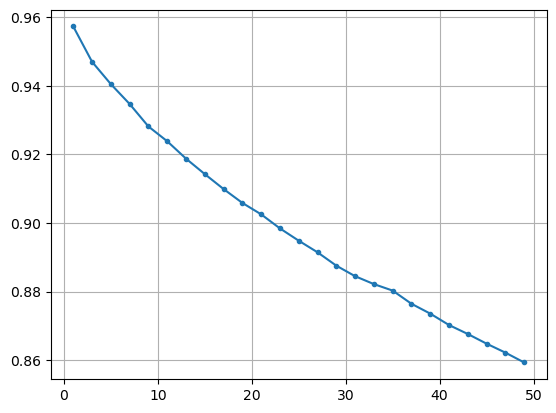

In [18]:
ks=np.arange(1,50,2) 
ac=np.zeros(ks.shape[0])
for i,k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xt_train, y_train)
    preds = knn.predict(Xt_test)
    ac[i]=accuracy_score(y_test, preds)

plt.plot(ks, ac, '.-')
plt.grid()
plt.show()

In [22]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Xt_train, y_train)
    
printClassResults(y_test, preds)

The Accuracy is:  0.8594
The Precision is:  0.8594
The Recall is:  0.8594
The F1 score is:  0.8594
The Matthews correlation coefficient is:  0.8262

This is the Confusion Matrix


,0,1,2,3,4
0,4056,9,7,0,0
1,40,3400,43,150,79
2,298,0,3482,333,2
3,129,42,532,2999,2
4,287,426,188,179,2841
